In [11]:
import torch

import albumentations as A
import albumentations.pytorch.transforms as A_transforms
import numpy as np

from torch.utils.data import DataLoader

import conf as cfg

from custom_dataloader import CustomDataset

import warnings
warnings.filterwarnings('ignore')

In [12]:

def save_checkpoint(epoch, model, optimizer):
    state = {'epoch': epoch,
             'model': model,
             'optimizer': optimizer}
    filename = 'checkpoint_ssd300.pth.tar'
    torch.save(state, filename)
    
    
def clip_gradient(optimizer, grad_clip):
    for group in optimizer.param_groups:
        for param in group['params']:
            if param.grad is not None:
                param.grad.data.clamp_(-grad_clip, grad_clip)    

In [13]:
train_transform = A.Compose([A.Resize(300, 300),
                             A.Normalize(),
                             A_transforms.ToTensorV2()
                             ],
                            bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))


train_dataset = CustomDataset(split='TRAINVAL', apply_transform=train_transform)
train_dataloader = DataLoader(train_dataset, batch_size=2, collate_fn=train_dataset.collate_fn, shuffle=False, pin_memory=True)

In [14]:
from models import SSD300, MultiBoxLoss

lr = 1e-3
momentum = 0.9
weight_decay = 5e-4

start_epoch = 0
biases = []
not_biases = []

model = SSD300(n_classes=len(cfg.voc_labels) + 1).to(cfg.DEVICE)

for param_name, param in model.named_parameters():
    if param.requires_grad:
        if param_name.endswith('.bias'):
            biases.append(param)
            
        else:
            not_biases.append(param)

optimizer = torch.optim.SGD(params=[{'params': biases, 'lr': 2 * lr}, {'params': not_biases}],
                            lr=lr, momentum=momentum, weight_decay=weight_decay)

criterion = MultiBoxLoss(anchor_boxes=model.anchor_boxes).to(cfg.DEVICE)

best_loss = np.inf


for epoch in range(200):        
    train_avg_loss = 0
    valid_avg_loss = 0
    
    model.train()
    for train_minibatch, (train_batch_images, train_batch_bboxes, train_batch_classes) in enumerate(train_dataloader):        
        images = train_batch_images.to(cfg.DEVICE)
        boxes = [b.to(cfg.DEVICE) for b in train_batch_bboxes]
        labels = [l.to(cfg.DEVICE) for l in train_batch_classes]
        
        pred_loc, pred_cls = model(images)
        loss = criterion(pred_loc, pred_cls, boxes, labels)
        
        optimizer.zero_grad()
        loss.backward()
        
        clip_gradient(optimizer, 5)
        optimizer.step()
        
        train_avg_loss = (train_avg_loss * train_minibatch + loss.item()) / (train_minibatch + 1)        
        
        print(f"Epoch: {epoch+1}\tBatch: {train_minibatch+1}/{len(train_dataloader)}\tTrain Loss: {train_avg_loss:2f}", end='\r')
    print()

Epoch: 1	Batch: 1/1	Train Loss: 119.201065
Epoch: 2	Batch: 1/1	Train Loss: 87.982414
Epoch: 3	Batch: 1/1	Train Loss: 44.539200
Epoch: 4	Batch: 1/1	Train Loss: 18.234577
Epoch: 5	Batch: 1/1	Train Loss: 17.478525
Epoch: 6	Batch: 1/1	Train Loss: 16.932024
Epoch: 7	Batch: 1/1	Train Loss: 16.392017
Epoch: 8	Batch: 1/1	Train Loss: 16.146549
Epoch: 9	Batch: 1/1	Train Loss: 15.959516
Epoch: 10	Batch: 1/1	Train Loss: 15.826984
Epoch: 11	Batch: 1/1	Train Loss: 15.719177
Epoch: 12	Batch: 1/1	Train Loss: 15.621752
Epoch: 13	Batch: 1/1	Train Loss: 15.542234
Epoch: 14	Batch: 1/1	Train Loss: 15.470150
Epoch: 15	Batch: 1/1	Train Loss: 15.386703
Epoch: 16	Batch: 1/1	Train Loss: 15.301883
Epoch: 17	Batch: 1/1	Train Loss: 15.209801
Epoch: 18	Batch: 1/1	Train Loss: 15.108971
Epoch: 19	Batch: 1/1	Train Loss: 14.986820
Epoch: 20	Batch: 1/1	Train Loss: 14.845671
Epoch: 21	Batch: 1/1	Train Loss: 14.690237
Epoch: 22	Batch: 1/1	Train Loss: 14.507261
Epoch: 23	Batch: 1/1	Train Loss: 14.294217
Epoch: 24	Batch: 1/

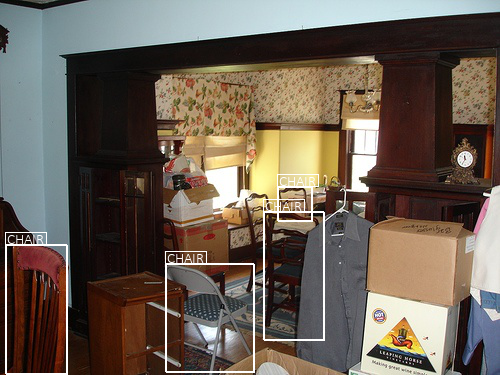

In [20]:
from utils import *
from PIL import Image, ImageDraw, ImageFont
import conf as cfg

model.eval()

min_score = 0.2
max_overlap = 0.5
top_n = 1000
suppress = True

A_inference = A.Compose([A.Resize(300, 300),
                      A.Normalize(),
                      A_transforms.ToTensorV2()
                      ])

img_path = '../dataset/voc/VOCdevkit/VOC2007/JPEGImages/000005.jpg'
original_image = Image.open(img_path)
aug_image = np.array(original_image)


aug_image = A_inference(image=aug_image)['image']
aug_image = aug_image.to(cfg.DEVICE)

predicted_locs, predicted_scores = model(aug_image.unsqueeze(0))

pred_bboxes, pred_labels, _ = model.inference(predicted_locs, predicted_scores, min_score=min_score,
                                                            max_overlap=max_overlap, top_n=top_n)

pred_bboxes = pred_bboxes[0].to('cpu')

original_dims = torch.FloatTensor([original_image.width, original_image.height, original_image.width, original_image.height]).unsqueeze(0)
pred_bboxes = pred_bboxes * original_dims

pred_labels = [cfg.REVERSE_CLASSES_DICT[l + 1] for l in pred_labels[0].to('cpu').tolist()]

annotated_image = original_image
draw = ImageDraw.Draw(annotated_image)
font = ImageFont.truetype("./calibril.ttf", 15)

for i in range(pred_bboxes.size(0)):
    box_location = pred_bboxes[i].tolist()
    draw.rectangle(xy=box_location)
    draw.rectangle(xy=[l + 1. for l in box_location])

    text_size = font.getsize(pred_labels[i].upper())
    text_location = [box_location[0] + 2., box_location[1] - text_size[1]]
    textbox_location = [box_location[0], box_location[1] - text_size[1], box_location[0] + text_size[0] + 4.,
                        box_location[1]]
    draw.rectangle(xy=textbox_location)
    draw.text(xy=text_location, text=pred_labels[i].upper(), fill='white',
                font=font)
    
annotated_image